# Potential Navigation

An implementation of potential navigation

In [1]:
import sys, os

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
from typing import List, Tuple
from copy import copy

In [3]:
# Install from package at https://github.com/iwishiwasaneagle/jsim/releases/latest
from jsim.Simulation import Simulation
from jsim.Agent import Agent
from jsim.Environment import Environment
from jsim.Meta import Action, State

In [4]:
class Force(Action):
    def __init__(self, x=0.0, y=0.0) -> None:
        super().__init__()

        self.x = x
        self.y = y


class XYState(State):
    def __init__(self, x=0, y=0) -> None:
        super().__init__()

        self.x = x
        self.y = y


class Position(XYState):
    pass


class Velocity(XYState):
    pass


class Acceleration(XYState):
    pass


class PhysicalState(State):
    def __init__(self, position=None, velocity=None, acceleration=None) -> None:
        super().__init__()
        if position is None:
            position = Position()

        if velocity is None:
            velocity = Velocity()

        if acceleration is None:
            acceleration = Acceleration()

        self.pos = position
        self.vel = velocity
        self.acc = acceleration

In [5]:
class PotentialAgent(Agent):
    def __init__(self, *args) -> None:
        super().__init__(*args)

        self.reset(PhysicalState())

    def reset(self, ps: PhysicalState) -> Force:
        super().reset(ps)
        return self.policy(ps)

    def step(
        self, ps: PhysicalState, pa: Force, pnext_s: PhysicalState, reward: float
    ) -> Force:
        return self.policy(self.state)

    def update(self, pa: Force) -> PhysicalState:
        fx, fy = pa.x, pa.y

        self.state.acc.x = fx * 0.1 - 0.4 * self.state.vel.x
        self.state.acc.y = fy * 0.1 - 0.4 * self.state.vel.y

        self.state.vel.x += self.state.acc.x * self.psim.dt
        self.state.vel.y += self.state.acc.y * self.psim.dt

        self.state.pos.x += self.state.vel.x * self.psim.dt
        self.state.pos.y += self.state.vel.y * self.psim.dt

        return self.state

    def policy(self, pnext_s: PhysicalState) -> Force:
        """
        The agent wants to get to (20,20).

        Simple potential function following to the minima.

        .. math::
            f_x = \\frac{d}{dx} [ (x-20)^2 + (y-20)^2 ] = 2(x-20)

            f_y = \\frac{d}{dy} [ (x-20)^2 + (y-20)^2 ] = 2(y-20)
        """

        fx = -2 * (pnext_s.pos.x - 20)  # minus to make it go towards the centre
        fy = -2 * (pnext_s.pos.y - 20)

        return Force(fx, fy)

In [6]:
class PotentialEnv(Environment):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def reset(self) -> None:
        """
        This env has no memory or physicalness to it.
        """
        pass

    def step(self) -> Tuple[None, float]:
        """
        This env has no memory or physicalness to it.
        """
        return None, 0

In [7]:
class PotentialSim(Simulation):
    env: PotentialEnv
    agent: PotentialAgent

    def __init__(self, dt=0.1) -> None:
        self.pos_arr = []
        self.env = PotentialEnv(self)
        self.agent = PotentialAgent(self,self.env)
        self.dt = dt
        super().__init__()

    def reset(self) -> None:
        self.env_s = self.env.reset()
        self.agent_s = PhysicalState(
            position=Position(*(20 + 5 * np.random.normal(0, (2, 1)))),
            velocity=Velocity(*np.random.rand(2) * 5),
        )
        self.agent_a = self.agent.reset(self.agent_s)

    def collect_data(self, ps: PhysicalState) -> None:
        self.pos_arr.append((ps.pos.x, ps.pos.y))

    def steps(self, num_steps: int) -> None:
        for i in range(num_steps):

            agent_a = self.agent.step(self.agent_s, self.agent_a, None, 0)
            agent_s = self.agent.update(agent_a)

            self.collect_data(agent_s)

            if agent_s != 0:
                self.agent_a = agent_a
                self.agent_s = agent_s
            else:
                self.reset()
                logger.info(f"Trial completed after {i}/{num_steps} steps")
                return

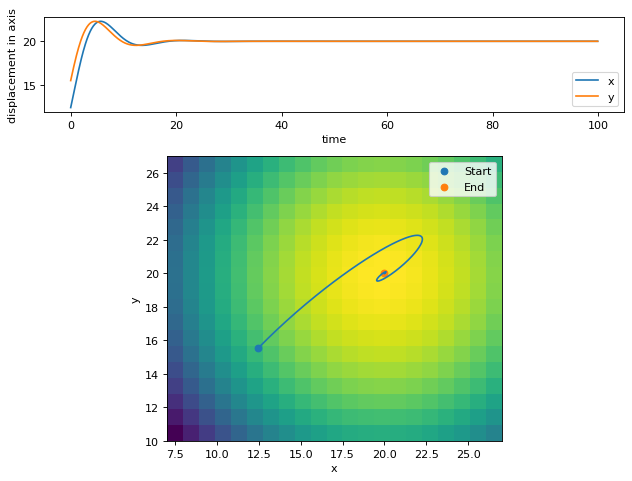

In [8]:

mysim = PotentialSim()
mysim.steps(1000)

pos_x = [p[0] for p in mysim.pos_arr]
pos_y = [p[1] for p in mysim.pos_arr]
t = [mysim.dt * i for i in range(len(pos_x))]

fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios': [1, 3]},figsize=(8, 6), dpi=80)

ax1.plot(t, pos_x,label='x')
ax1.plot(t, pos_y,label='y')
ax1.set_ylabel('displacement in axis')
ax1.set_xlabel('time')
ax1.legend()

x,y = np.meshgrid(
        np.arange(
            np.floor(min(pos_x))-5,
            np.ceil(max(pos_x))+5
            ),
        np.arange(
            np.floor(min(pos_y))-5,
            np.ceil(max(pos_y))+5
            )
        )
z = (x-20)**2 + (y-20)**2
ax2.imshow(-z, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)])
ax2.plot(pos_x, pos_y)
ax2.scatter(pos_x[0], pos_y[0], label="Start")
ax2.scatter(pos_x[-1], pos_y[-1], label="End")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend()

fig.tight_layout()